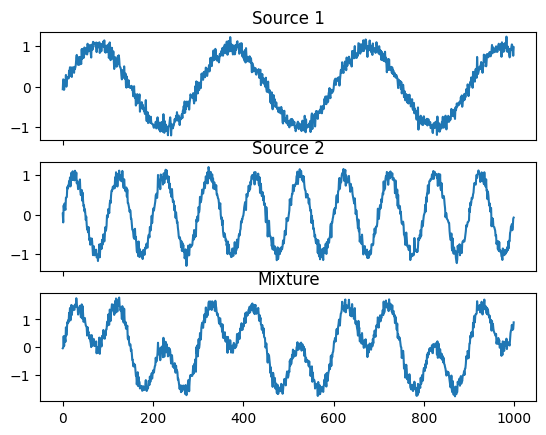

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T = 1000
t = np.arange(0, T)
fs = 3000
f0 = 10

source1 = np.sin(2*np.pi*(f0/fs)*t) + 0.1*np.random.randn(T)
source2 = np.sin(2*np.pi*(3*f0/fs)*t)+ 0.1*np.random.randn(T)
mixture = source1 + source2

plt.subplot(311)
plt.plot(source1)
plt.title('Source 1')
plt.xticks(np.arange(0, 100, T), '')

plt.subplot(312)
plt.plot(source2)
plt.title('Source 2')
plt.xticks(np.arange(0, 100, T), '')

plt.subplot(313)
plt.plot(mixture)
plt.title('Mixture')
plt.show()

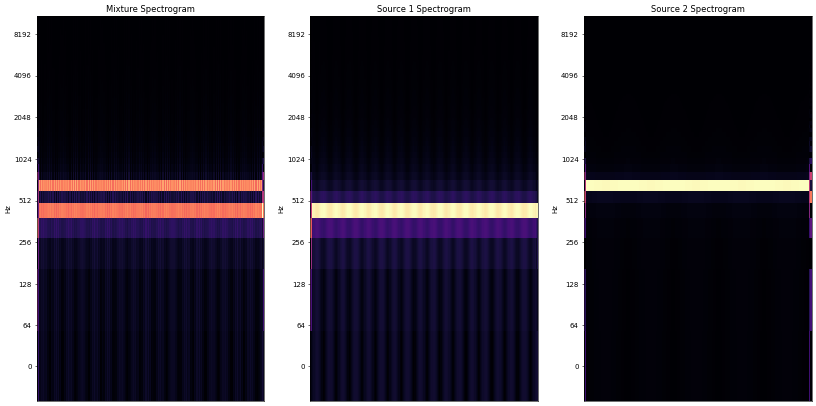

In [ ]:
import torch
import torch.utils.data as data_utils
import librosa.display as lrd

N = 100
f_th = 200
fs = 8000

T = 10000
t = torch.arange(0, T).unsqueeze(0)
f1 = torch.randint(5, f_th, (N, 1))
f2 = torch.randint(f_th, 400, (N, 1))
batch_size = 10

source1 = torch.sin(2*np.pi*(f1/fs)*t)
source2 = torch.sin(2*np.pi*(f2/fs)*t)
mixture = source1 + source2
N_train = 90
train_dataset = data_utils.TensorDataset(source1[:N_train], source2[:N_train], mixture[:N_train])
test_dataset = data_utils.TensorDataset(source1[N_train:], source2[N_train:], mixture[N_train:])

train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size)
test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size)

# now let's visualize the frequency spectra for the dataset
fft_size = 200

plt.figure(figsize=[20, 10], dpi=50)

plt.subplot(131)
mix_gt = mixture[N_train]
mix_spec = torch.sqrt((torch.view_as_real(torch.stft(mix_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(mix_spec.numpy(), y_axis='log')
plt.title('Mixture Spectrogram')

plt.subplot(132)
source1_gt = source1[N_train]
source1_spec = torch.sqrt((torch.view_as_real(torch.stft(source1_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(source1_spec.numpy(), y_axis='log')
plt.title('Source 1 Spectrogram')

plt.subplot(133)
source2_gt = source2[N_train]
source2_spec = torch.sqrt((torch.view_as_real(torch.stft(source2_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(source2_spec.numpy(), y_axis='log')
plt.title('Source 2 Spectrogram')

plt.show()


In [ ]:
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 45.6 MB/s eta 0:00:00


In [ ]:
import speechbrain as sb
import torch.nn as nn

# define the model
class simpleseparator(nn.Module):
  def __init__(self, fft_size, hidden_size, num_sources=2):
    super(simpleseparator, self).__init__()
    self.masking = nn.LSTM(input_size=fft_size//2 + 1, hidden_size=hidden_size, batch_first=True, bidirectional=True)
    self.output_layer = nn.Linear(in_features=hidden_size*2, out_features=num_sources*(fft_size//2 + 1))
    self.fft_size=fft_size
    self.num_sources = num_sources

  def forward(self, inp):
    # batch x freq x time x realim
    y = torch.view_as_real(torch.stft(inp, n_fft=self.fft_size, return_complex=True))

    # batch X freq x time
    mag = torch.sqrt((y ** 2).sum(-1))
    phase = torch.atan2(y[:, :, :, 1], y[:, :, :, 0])

    # batch x time x freq
    mag = mag.permute(0, 2, 1)

    # batch x time x feature
    rnn_out = self.masking(mag)[0]

    # batch x time x (nfft*num_sources)
    lin_out = self.output_layer(rnn_out)

    # batch x time x nfft x num_sources
    lin_out = nn.functional.relu(lin_out.reshape(lin_out.size(0), lin_out.size(1), -1, self.num_sources))

    # reconstruct in time domain
    sources = []
    all_masks = []
    for n in range(self.num_sources):
      sourcehat_mask = (lin_out[:, :, :, n])
      all_masks.append(sourcehat_mask)

      # multiply with mask and magnitude
      sourcehat_dft = (sourcehat_mask * mag).permute(0, 2, 1) * torch.exp(1j * phase)

      # reconstruct in time domain with istft
      sourcehat = torch.istft(sourcehat_dft, n_fft=self.fft_size)
      sources.append(sourcehat)
    return sources, all_masks, mag

# test_forwardpass
model = simpleseparator(fft_size=fft_size, hidden_size=300)
est_sources, _, _ = model.forward(mixture[:5])

In [ ]:
class SeparationBrain(sb.Brain):
    def __init__(self, train_loss, modules, opt_class):
        super(SeparationBrain, self).__init__(modules=modules, opt_class=opt_class)
        self.train_loss = train_loss

    def compute_forward(self, mix):
        """Forward computations from the mixture to the separated signals."""

        # Get the estimates for the sources
        est_sources, _, _ = self.modules.mdl(mix)

        est_sources = torch.stack(est_sources, dim=-1)

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_sources.size(1)
        if T_origin > T_est:
            est_sources = nn.functional.pad(est_sources, (0, 0, 0, T_origin - T_est))
        else:
            est_sources = est_sources[:, :T_origin, :]

        return est_sources

    def compute_objectives(self, targets, est_sources):
        """Computes the loss functions between estimated and ground truth sources"""
        if self.train_loss == 'l1':
          return (est_sources - targets).abs().mean()
        elif self.train_loss == 'si-snr':
          return sb.nnet.losses.get_si_snr_with_pitwrapper(targets, est_sources).mean()


    def fit_batch(self, batch):
        """Trains one batch"""
        # Unpacking batch list
        source1, source2, mix = batch
        targets = torch.stack([source1, source2], dim=-1)

        est_sources = self.compute_forward(mix)
        loss = self.compute_objectives(targets, est_sources)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for test batches"""

        source1, source2, mix = batch
        targets = torch.stack([source1, source2], dim=-1)

        est_sources = self.compute_forward(mix)

        si_snr = sb.nnet.losses.get_si_snr_with_pitwrapper(targets, est_sources)
        si_snr_mean = si_snr.mean().item()
        print('VALID SI-SNR = {}'.format(-si_snr_mean))
        return si_snr.mean().detach()


from functools import partial

optimizer = lambda x: torch.optim.Adam(x, lr=0.0001)
N_epochs = 10
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
        train_loss='l1',
        modules={'mdl': model},
        opt_class=optimizer

    )


separator.fit(
            epoch_counter,
            train_loader,
            test_loader)


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


VALID SI-SNR = 3.771345615386963


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


VALID SI-SNR = 9.128641128540039


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


VALID SI-SNR = 14.631914138793945


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


VALID SI-SNR = 17.590381622314453


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


VALID SI-SNR = 19.07602310180664


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


VALID SI-SNR = 19.729026794433594


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


VALID SI-SNR = 20.268062591552734


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


VALID SI-SNR = 20.662899017333984


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


VALID SI-SNR = 20.86262321472168


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

VALID SI-SNR = 20.969507217407227


In [ ]:
!pip install librosa

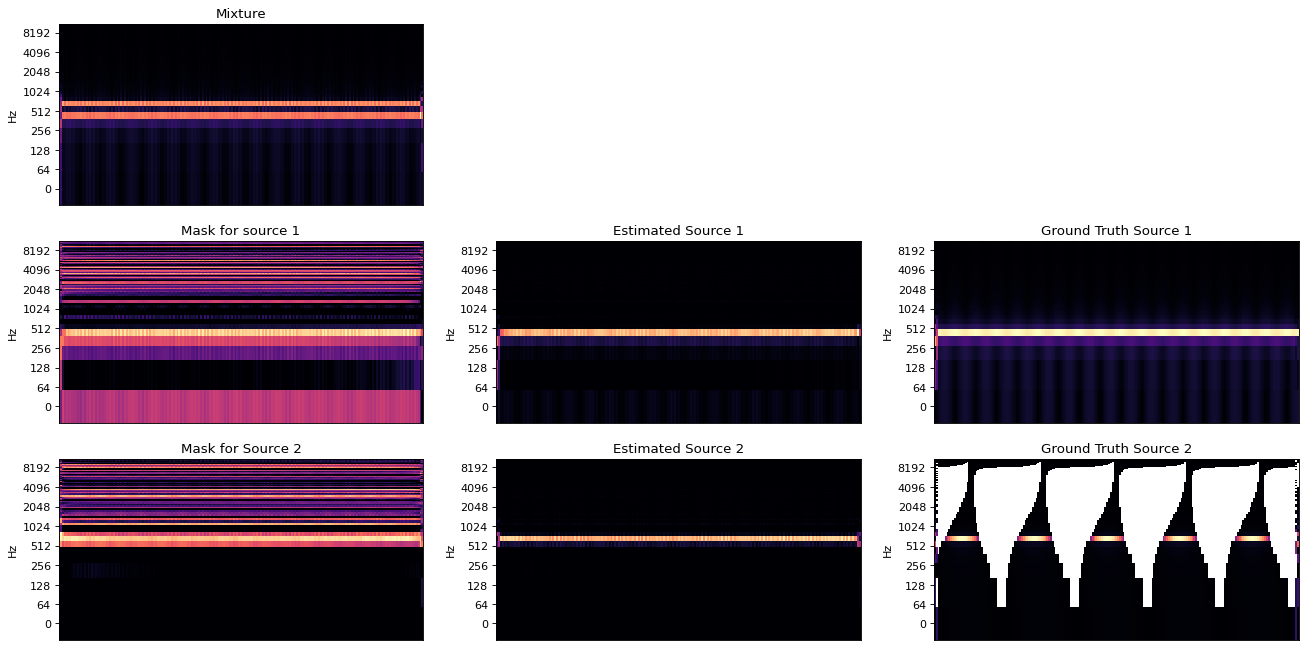

In [ ]:
estimated_sources, all_masks, mag = separator.modules.mdl.forward(mixture[N_train:])


plt.figure(figsize=[20, 10], dpi=80)

plt.subplot(331)
mag = mag[0].t().numpy()
lrd.specshow(mag, y_axis='log')
plt.title('Mixture')

plt.subplot(334)
mask1 = all_masks[0][0].detach().t().numpy()
lrd.specshow(mask1, y_axis='log')
plt.title('Mask for source 1')

plt.subplot(335)
masked1 = mask1 * mag
lrd.specshow(masked1, y_axis='log')
plt.title('Estimated Source 1')

plt.subplot(336)
source1_gt = source1[N_train]
source1_spec = torch.sqrt((torch.view_as_real(torch.stft(source1_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(source1_spec.numpy(), y_axis='log')
plt.title('Ground Truth Source 1')

plt.subplot(337)
mask2 = all_masks[1][0].detach().t().numpy()
lrd.specshow(mask2, y_axis='log')
plt.title('Mask for Source 2')

plt.subplot(338)
masked2 = mask2 * mag
lrd.specshow(masked2, y_axis='log')
plt.title('Estimated Source 2')

plt.subplot(339)
source2_gt = source2[N_train]
source2_spec = torch.sqrt((torch.view_as_real(torch.stft(source2_gt, n_fft=fft_size, return_complex=True)**2)).sum(-1))
lrd.specshow(source2_spec.numpy(), y_axis='log')
plt.title('Ground Truth Source 2')

plt.show()


In [ ]:
%%capture
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AADx5I8oV0IdekCf80MSkxMia/mixture_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAAZI7ZezKyHFGPdus6hn2v_a/mixture_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACh4Yy4H-Ii2I0mr_b1lQdXa/mixture_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAAenTlEsoj1-AGbCxeJfMHoa/mixture_3.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC-awQo-9NFVVULuVwaHKKWa/source1_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AABVKWtdVhXZE6Voq1I_c6g5a/source1_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC9EfjTTwL0dscH16waP9s-a/source1_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC5Ozb4rS9qby268JSIy5Uwa/source1_3.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AABlonG910Ms2l-rTN5ct3Oka/source2_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACDOqEgyXIeA2r1Rkf7VgQTa/source2_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACTYGAG0LOh6HvxpVYoqO_Da/source2_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACPmq-ZJNzfh4bnO34_8mfAa/source2_3.wav

In [ ]:
import speechbrain
from speechbrain.dataio.dataio import read_audio
from IPython.display import Audio

mixture_0 = read_audio('mixture_0.wav').squeeze()
source1_0 = read_audio('source1_0.wav').squeeze()
source2_0 = read_audio('source2_0.wav').squeeze()

mixture_1 = read_audio('mixture_1.wav').squeeze()
source1_1 = read_audio('source1_1.wav').squeeze()
source2_1 = read_audio('source2_1.wav').squeeze()

mixture_2 = read_audio('mixture_2.wav').squeeze()
source1_2 = read_audio('source1_2.wav').squeeze()
source2_2 = read_audio('source2_2.wav').squeeze()

mixture_3 = read_audio('mixture_3.wav').squeeze()
source1_3 = read_audio('source1_3.wav').squeeze()
source2_3 = read_audio('source2_3.wav').squeeze()

train_mixs = [mixture_0, mixture_1, mixture_2]
train_source1s = [source1_0, source1_1, source1_2]
train_source2s = [source2_0, source2_1, source2_2]

Audio(mixture_0, rate=16000)

In [ ]:
from torch.utils.data import Dataset, DataLoader


class source_separation_dataset(Dataset):
    def __init__(self, train_mixs, train_source1s, train_source2s):
        self.mixs = train_mixs
        self.train_source1s = train_source1s
        self.train_source2s = train_source2s

    def __len__(self):
        return len(self.mixs)

    def __getitem__(self, idx):
        mix = self.mixs[idx]
        source1 = self.train_source1s[idx]
        source2 = self.train_source2s[idx]
        return mix, source1, source2

train_dataset_audio = source_separation_dataset(train_mixs, train_source1s, train_source2s)
valid_dataset_audio = source_separation_dataset([mixture_2], [source1_2], [source2_2])

train_loader_audio = DataLoader(train_dataset_audio, batch_size=1)
valid_loader_audio = DataLoader(valid_dataset_audio, batch_size=1)


In [ ]:
fft_size=1024
model_audio = simpleseparator(fft_size=fft_size, hidden_size=300)


optimizer = lambda x: torch.optim.Adam(x, lr=0.0005)
N_epochs = 100
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
        train_loss='si-snr',
        modules={'mdl': model_audio},
        opt_class=optimizer

    )


separator.fit(
            epoch_counter,
            train_loader_audio,
            valid_loader_audio)



100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


VALID SI-SNR = -20.580427169799805


100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


VALID SI-SNR = -18.611919403076172


100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


VALID SI-SNR = -17.298690795898438


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


VALID SI-SNR = -16.528011322021484


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


VALID SI-SNR = -15.85414981842041


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


VALID SI-SNR = -15.192329406738281


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


VALID SI-SNR = -14.54704475402832


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


VALID SI-SNR = -13.771835327148438


100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


VALID SI-SNR = -12.836443901062012


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


VALID SI-SNR = -12.144689559936523


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


VALID SI-SNR = -11.490619659423828


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


VALID SI-SNR = -11.091400146484375


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


VALID SI-SNR = -10.61306095123291


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


VALID SI-SNR = -10.231002807617188


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


VALID SI-SNR = -9.833274841308594


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


VALID SI-SNR = -9.514118194580078


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


VALID SI-SNR = -9.229768753051758


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


VALID SI-SNR = -8.939709663391113


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


VALID SI-SNR = -8.622847557067871


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


VALID SI-SNR = -8.118059158325195


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


VALID SI-SNR = -7.9705939292907715


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


VALID SI-SNR = -7.73124361038208


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


VALID SI-SNR = -7.420276165008545


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


VALID SI-SNR = -7.237325668334961


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


VALID SI-SNR = -7.095833778381348


100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


VALID SI-SNR = -6.833159446716309


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


VALID SI-SNR = -6.650657653808594


100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


VALID SI-SNR = -6.451737880706787


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


VALID SI-SNR = -6.277789115905762


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


VALID SI-SNR = -6.193449020385742


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


VALID SI-SNR = -6.1081223487854


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


VALID SI-SNR = -5.99045467376709


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


VALID SI-SNR = -5.881477355957031


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


VALID SI-SNR = -5.804666996002197


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


VALID SI-SNR = -5.711592197418213


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


VALID SI-SNR = -5.5780205726623535


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


VALID SI-SNR = -5.5676751136779785


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


VALID SI-SNR = -5.453951358795166


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


VALID SI-SNR = -5.592049598693848


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


VALID SI-SNR = -5.231349945068359


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


VALID SI-SNR = -5.171456336975098


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


VALID SI-SNR = -5.004044532775879


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


VALID SI-SNR = -4.895715236663818


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


VALID SI-SNR = -4.708422660827637


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


VALID SI-SNR = -4.593300819396973


100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


VALID SI-SNR = -4.486862659454346


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


VALID SI-SNR = -4.316722869873047


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


VALID SI-SNR = -4.219691276550293


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


VALID SI-SNR = -4.181511402130127


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


VALID SI-SNR = -4.220924377441406


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


VALID SI-SNR = -4.129476547241211


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


VALID SI-SNR = -4.076281547546387


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


VALID SI-SNR = -3.9083821773529053


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


VALID SI-SNR = -3.947019577026367


100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


VALID SI-SNR = -4.256339073181152


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


VALID SI-SNR = -4.154481410980225


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


VALID SI-SNR = -4.09751033782959


100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


VALID SI-SNR = -4.055655002593994


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


VALID SI-SNR = -3.845478057861328


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


VALID SI-SNR = -3.7160706520080566


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


VALID SI-SNR = -3.6203129291534424


100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


VALID SI-SNR = -3.53332257270813


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


VALID SI-SNR = -3.4178709983825684


100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


VALID SI-SNR = -3.385221481323242


100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


VALID SI-SNR = -3.3674283027648926


100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


VALID SI-SNR = -3.2041921615600586


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


VALID SI-SNR = -3.4683094024658203


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


VALID SI-SNR = -3.300006151199341


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


VALID SI-SNR = -3.167933702468872


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


VALID SI-SNR = -3.267977476119995


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


VALID SI-SNR = -3.4130547046661377


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


VALID SI-SNR = -3.3051578998565674


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


VALID SI-SNR = -3.329434871673584


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


VALID SI-SNR = -3.3427538871765137


100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


VALID SI-SNR = -3.3602542877197266


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


VALID SI-SNR = -3.3454596996307373


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


VALID SI-SNR = -3.707885265350342


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


VALID SI-SNR = -3.5734453201293945


100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


VALID SI-SNR = -3.7271811962127686


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


VALID SI-SNR = -3.634744167327881


100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


VALID SI-SNR = -3.5483641624450684


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


VALID SI-SNR = -3.514228105545044


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


VALID SI-SNR = -3.3571901321411133


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


VALID SI-SNR = -3.2730352878570557


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


VALID SI-SNR = -3.228104591369629


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


VALID SI-SNR = -3.154221534729004


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


VALID SI-SNR = -3.1608211994171143


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


VALID SI-SNR = -3.1571240425109863


100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


VALID SI-SNR = -3.0862274169921875


100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


VALID SI-SNR = -3.2538511753082275


100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


VALID SI-SNR = -3.136064291000366


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


VALID SI-SNR = -3.20086669921875


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


VALID SI-SNR = -3.1505002975463867


100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


VALID SI-SNR = -3.0755250453948975


100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


VALID SI-SNR = -3.114201068878174


100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


VALID SI-SNR = -3.0151004791259766


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


VALID SI-SNR = -2.9346139430999756


100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


VALID SI-SNR = -2.929288864135742


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


VALID SI-SNR = -2.8773021697998047


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

VALID SI-SNR = -2.87544584274292


In [ ]:
class audioseparator(nn.Module):
  def __init__(self, fft_size, hidden_size, num_sources=2, kernel_size=16):
    super(audioseparator, self).__init__()
    self.encoder = nn.Conv1d(in_channels=1, out_channels=fft_size, kernel_size=16, stride=kernel_size//2)

    # MaskNet
    self.rnn = nn.LSTM(input_size=fft_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
    self.output_layer = nn.Linear(in_features=hidden_size*2, out_features=num_sources*(fft_size))

    self.decoder = nn.ConvTranspose1d(in_channels=fft_size, out_channels=1, kernel_size=kernel_size, stride=kernel_size//2)

    self.fft_size = fft_size
    self.hidden_size = hidden_size
    self.num_sources = num_sources

  def forward(self, inp):
    # batch x channels x time
    y = nn.functional.relu(self.encoder(inp.unsqueeze(0)))

    # batch x time x nfft
    y = y.permute(0, 2, 1)

    # batch x time x feature
    rnn_out = self.rnn(y)[0]

    # batch x time x (nfft*num_sources)
    lin_out = self.output_layer(rnn_out)

    # batch x time x nfft x num_sources
    lin_out = lin_out.reshape(lin_out.size(0), lin_out.size(1), -1, self.num_sources)

    # reconstruct in time domain
    sources = []
    all_masks = []
    for n in range(self.num_sources):
      sourcehat_mask = nn.functional.relu(lin_out[:, :, :, n])
      all_masks.append(sourcehat_mask)

      # multiply with mask and magnitude
      T = sourcehat_mask.size(1)
      sourcehat_latent = (sourcehat_mask * y[:, :T, :]).permute(0, 2, 1)

      # reconstruct in time domain with istft
      sourcehat = self.decoder(sourcehat_latent).squeeze(0)
      sources.append(sourcehat)

    return sources, all_masks, y

model_audio = audioseparator(fft_size=fft_size, hidden_size=300, kernel_size=256)
out, _, _ = model_audio.forward(mixture_0.unsqueeze(0))


In [ ]:
optimizer = lambda x: torch.optim.Adam(x, lr=0.0002)
N_epochs = 200
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
        train_loss='si-snr',
        modules={'mdl': model_audio},
        opt_class=optimizer

    )

separator.fit(
            epoch_counter,
            train_loader_audio,
            valid_loader_audio)


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


VALID SI-SNR = -47.29430389404297


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


VALID SI-SNR = -34.936279296875


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


VALID SI-SNR = -30.413677215576172


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


VALID SI-SNR = -28.734119415283203


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


VALID SI-SNR = -27.64995574951172


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


VALID SI-SNR = -26.86258316040039


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


VALID SI-SNR = -26.19245147705078


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


VALID SI-SNR = -25.593793869018555


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


VALID SI-SNR = -25.05513572692871


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -24.55047607421875


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


VALID SI-SNR = -24.078828811645508


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


VALID SI-SNR = -23.636281967163086


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


VALID SI-SNR = -23.218116760253906


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


VALID SI-SNR = -22.82857894897461


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


VALID SI-SNR = -22.455585479736328


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


VALID SI-SNR = -22.096458435058594


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -21.747779846191406


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


VALID SI-SNR = -21.408660888671875


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


VALID SI-SNR = -21.07253074645996


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


VALID SI-SNR = -20.74080467224121


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


VALID SI-SNR = -20.414955139160156


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


VALID SI-SNR = -20.0930233001709


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


VALID SI-SNR = -19.770647048950195


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


VALID SI-SNR = -19.451833724975586


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


VALID SI-SNR = -19.13032341003418


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


VALID SI-SNR = -18.817995071411133


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


VALID SI-SNR = -18.513986587524414


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


VALID SI-SNR = -18.212875366210938


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


VALID SI-SNR = -17.923547744750977


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


VALID SI-SNR = -17.647830963134766


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


VALID SI-SNR = -17.381790161132812


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


VALID SI-SNR = -17.12518310546875


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


VALID SI-SNR = -16.878936767578125


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


VALID SI-SNR = -16.63983154296875


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


VALID SI-SNR = -16.40945053100586


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


VALID SI-SNR = -16.183917999267578


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


VALID SI-SNR = -15.964564323425293


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -15.751341819763184


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


VALID SI-SNR = -15.547167778015137


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


VALID SI-SNR = -15.347442626953125


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


VALID SI-SNR = -15.15211009979248


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


VALID SI-SNR = -14.960773468017578


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


VALID SI-SNR = -14.777441024780273


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


VALID SI-SNR = -14.597062110900879


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


VALID SI-SNR = -14.419778823852539


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


VALID SI-SNR = -14.244659423828125


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


VALID SI-SNR = -14.077770233154297


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


VALID SI-SNR = -13.907374382019043


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


VALID SI-SNR = -13.743367195129395


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


VALID SI-SNR = -13.589908599853516


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


VALID SI-SNR = -13.438886642456055


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


VALID SI-SNR = -13.284276962280273


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


VALID SI-SNR = -13.132469177246094


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


VALID SI-SNR = -12.985095024108887


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


VALID SI-SNR = -12.84412670135498


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


VALID SI-SNR = -12.702512741088867


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


VALID SI-SNR = -12.561136245727539


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


VALID SI-SNR = -12.42648983001709


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


VALID SI-SNR = -12.29983139038086


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


VALID SI-SNR = -12.171874046325684


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


VALID SI-SNR = -12.044367790222168


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


VALID SI-SNR = -11.92077350616455


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


VALID SI-SNR = -11.803325653076172


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


VALID SI-SNR = -11.68732738494873


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


VALID SI-SNR = -11.57302474975586


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -11.463159561157227


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


VALID SI-SNR = -11.355694770812988


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -11.249993324279785


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


VALID SI-SNR = -11.148337364196777


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


VALID SI-SNR = -11.049745559692383


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


VALID SI-SNR = -10.950855255126953


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


VALID SI-SNR = -10.856086730957031


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -10.76486587524414


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


VALID SI-SNR = -10.674284934997559


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


VALID SI-SNR = -10.583301544189453


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


VALID SI-SNR = -10.4951753616333


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


VALID SI-SNR = -10.409643173217773


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


VALID SI-SNR = -10.32304573059082


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


VALID SI-SNR = -10.238203048706055


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


VALID SI-SNR = -10.15511703491211


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


VALID SI-SNR = -10.073891639709473


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


VALID SI-SNR = -9.993426322937012


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -9.914069175720215


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


VALID SI-SNR = -9.837697982788086


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


VALID SI-SNR = -9.760462760925293


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


VALID SI-SNR = -9.684225082397461


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


VALID SI-SNR = -9.610701560974121


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


VALID SI-SNR = -9.540765762329102


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


VALID SI-SNR = -9.469833374023438


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


VALID SI-SNR = -9.401168823242188


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


VALID SI-SNR = -9.334606170654297


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


VALID SI-SNR = -9.268415451049805


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -9.201865196228027


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


VALID SI-SNR = -9.140130996704102


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


VALID SI-SNR = -9.076927185058594


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


VALID SI-SNR = -9.016207695007324


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


VALID SI-SNR = -8.956561088562012


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


VALID SI-SNR = -8.895947456359863


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


VALID SI-SNR = -8.83570671081543


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


VALID SI-SNR = -8.776729583740234


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


VALID SI-SNR = -8.719030380249023


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


VALID SI-SNR = -8.659842491149902


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


VALID SI-SNR = -8.602757453918457


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


VALID SI-SNR = -8.545892715454102


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


VALID SI-SNR = -8.489120483398438


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


VALID SI-SNR = -8.431706428527832


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


VALID SI-SNR = -8.376678466796875


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


VALID SI-SNR = -8.321662902832031


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


VALID SI-SNR = -8.269570350646973


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -8.217586517333984


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


VALID SI-SNR = -8.166561126708984


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


VALID SI-SNR = -8.11486530303955


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


VALID SI-SNR = -8.065025329589844


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


VALID SI-SNR = -8.015825271606445


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


VALID SI-SNR = -7.9663472175598145


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


VALID SI-SNR = -7.916189670562744


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


VALID SI-SNR = -7.868110656738281


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


VALID SI-SNR = -7.817885875701904


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


VALID SI-SNR = -7.76941442489624


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


VALID SI-SNR = -7.7221784591674805


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


VALID SI-SNR = -7.673088550567627


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


VALID SI-SNR = -7.626306533813477


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


VALID SI-SNR = -7.578943252563477


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


VALID SI-SNR = -7.533581256866455


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


VALID SI-SNR = -7.488337516784668


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


VALID SI-SNR = -7.442209243774414


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


VALID SI-SNR = -7.396204948425293


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


VALID SI-SNR = -7.35175085067749


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


VALID SI-SNR = -7.307500839233398


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


VALID SI-SNR = -7.263925075531006


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


VALID SI-SNR = -7.220335960388184


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


VALID SI-SNR = -7.177302837371826


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


VALID SI-SNR = -7.136336803436279


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


VALID SI-SNR = -7.093660354614258


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


VALID SI-SNR = -7.051605224609375


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


VALID SI-SNR = -7.010743141174316


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


VALID SI-SNR = -6.971743583679199


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


VALID SI-SNR = -6.930426597595215


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


VALID SI-SNR = -6.890270233154297


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


VALID SI-SNR = -6.853195667266846


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


VALID SI-SNR = -6.811903953552246


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


VALID SI-SNR = -6.774501800537109


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


VALID SI-SNR = -6.7374725341796875


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


VALID SI-SNR = -6.700540542602539


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


VALID SI-SNR = -6.665606498718262


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


VALID SI-SNR = -6.628169059753418


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


VALID SI-SNR = -6.593214511871338


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -6.558669567108154


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


VALID SI-SNR = -6.525666236877441


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


VALID SI-SNR = -6.491861343383789


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


VALID SI-SNR = -6.456357479095459


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


VALID SI-SNR = -6.423954010009766


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -6.390808582305908


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


VALID SI-SNR = -6.358186721801758


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


VALID SI-SNR = -6.3239617347717285


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


VALID SI-SNR = -6.29212760925293


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


VALID SI-SNR = -6.259809970855713


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


VALID SI-SNR = -6.227247714996338


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


VALID SI-SNR = -6.196582794189453


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


VALID SI-SNR = -6.1660990715026855


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


VALID SI-SNR = -6.137506484985352


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


VALID SI-SNR = -6.107587814331055


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


VALID SI-SNR = -6.077666759490967


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


VALID SI-SNR = -6.047659873962402


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


VALID SI-SNR = -6.019007205963135


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


VALID SI-SNR = -5.98779821395874


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


VALID SI-SNR = -5.959699630737305


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


VALID SI-SNR = -5.930578708648682


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


VALID SI-SNR = -5.905871868133545


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


VALID SI-SNR = -5.875669956207275


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


VALID SI-SNR = -5.850011348724365


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -5.819311141967773


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


VALID SI-SNR = -5.7959442138671875


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


VALID SI-SNR = -5.7664971351623535


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


VALID SI-SNR = -5.740201950073242


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


VALID SI-SNR = -5.71254825592041


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


VALID SI-SNR = -5.685904026031494


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


VALID SI-SNR = -5.659664154052734


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


VALID SI-SNR = -5.634759902954102


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


VALID SI-SNR = -5.607773780822754


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


VALID SI-SNR = -5.582995891571045


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


VALID SI-SNR = -5.558150768280029


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


VALID SI-SNR = -5.5343122482299805


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


VALID SI-SNR = -5.509312152862549


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


VALID SI-SNR = -5.486083507537842


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


VALID SI-SNR = -5.460134983062744


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


VALID SI-SNR = -5.438852310180664


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -5.412603855133057


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


VALID SI-SNR = -5.390189170837402


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


VALID SI-SNR = -5.36147403717041


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


VALID SI-SNR = -5.341682434082031


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


VALID SI-SNR = -5.315129280090332


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


VALID SI-SNR = -5.292727470397949


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


VALID SI-SNR = -5.267909526824951


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


VALID SI-SNR = -5.251037120819092


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -5.227132320404053


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


VALID SI-SNR = -5.199549198150635


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


VALID SI-SNR = -5.181562423706055


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


VALID SI-SNR = -5.158196449279785


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

VALID SI-SNR = -5.1378679275512695


In [ ]:
estimated_sources_test, all_masks, mag = model_audio.forward(mixture_3.unsqueeze(0))
estimated_sources_train, all_masks, mag = model_audio.forward(mixture_0.unsqueeze(0))


Audio(estimated_sources_test[0].squeeze().detach(), rate=16000)


In [ ]:
Audio(estimated_sources_test[1].squeeze().detach(), rate=16000)


In [ ]:
Audio(estimated_sources_train[0].squeeze().detach(), rate=16000)

In [ ]:
Audio(estimated_sources_train[1].squeeze().detach(), rate=16000)